<a href="https://colab.research.google.com/github/derekmok/machine-vision-coursework/blob/main/Machine_Vision_Final_Lab_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git init .
!git remote add origin https://github.com/derekmok/machine-vision-coursework.git
!git pull origin main

!pip install -r requirements.txt

## Download the data

The data for this assignment has been made available and is downloadable to disk by running the below cell.


In [ ]:
import os

import boto3
from botocore import UNSIGNED
from botocore.config import Config

# Connect to S3 without authentication (public bucket)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket_name = 'prism-mvta'
prefix = 'training-and-validation-data/'
download_dir = './video-data'

os.makedirs(download_dir, exist_ok=True)

# List all objects in the S3 path
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

video_names = []

for page in pages:
    if 'Contents' not in page:
        print("No files found at the specified path! Go and complain to the TAs!")
        break

    for obj in page['Contents']:
        key = obj['Key']
        filename = os.path.basename(key)

        if not filename:
            continue

        video_names.append(filename)

        local_path = os.path.join(download_dir, filename)
        print(f"Downloading: {filename}")
        s3.download_file(bucket_name, key, local_path)

print("\n" + "="*50)
print("Downloaded videos:")
print("="*50)
for name in video_names:
    print(name)

print(f"\nTotal: {len(video_names)} files")

These videos are now available in the folder "video-data". You can click on the folder icon on the left-hand-side of this screen to see the videos in a file explorer.

# Create your Datasets and Dataloaders

Some example code for approaching the first *two* TODOs is given below just to get you started. No starter code is given for the third TODO.

Note, the below code is very rough skeleton code. Make no assumptions as to the correct manner to architect your model based on the structure of this code.

Please feel free to (if not encouraged to) change every single line of the below code (change it to best suit your chosen model architecture, in the next section).

### TODO 1 (This is mostly already done for you - Please see the v1 provided below)

Each video in the folder is prefixed by a number. That number corresponds to the number of distinct pushups visible in the video. Write code to iterate over each video in the folder, and extract the corresponding target associated with the video.

### TODO 2 (This is also mostly already done for you - Please see the v1 provided below)


Divide the data into training and validation sets.

Optionally, you can also create out your own test set to assess your performance.

### TODO 3

Any preprocessing or augmentation of your data which you deem required, should (probably) go here. You are also free to include your data-augmentation code later, though doing it before creating your dataloaders is probably a good idea.

If you complete this TODO, to maintain experimental hygiene, feel free to modify the code which was provided for TODOs 1 and 2.

In [1]:
# Dataset is implemented in "data_loader.py"
# Dataloaders are created in neural_net/ensemble_trainer.py
from neural_net.data_loader import VideoDataset

# Create a Model

For this assignment, we request you use PyTorch. Below is an example of how to instantiate a very basic PyTorch model.

Note, this model below needs a _lot_ of work.

Please include your code for creating your model below.

The only constraint here is that you define a Python object which inherits from a PyTorch nn.Module object. Beyond that, please feel free to implement anything you like: Transformer, Vision Transformer, MLP, CNN, etc.

### TODO 4

Create your model.

In [2]:
# The model is implemented in the "neural_net/temporal_conv_net.py"
# and "neural_net/ensemble_model.py"
from neural_net.temporal_conv_net import TCNPushUpCounter
from neural_net.ensemble_model import EnsembleModel

def create_ensemble_from_results(fold_results, input_channels=6):
    """Create an EnsembleModel and load weights from training results.
    
    Args:
        fold_results: List of FoldResult from training
        input_channels: Number of input channels for TCNPushUpCounter
        
    Returns:
        EnsembleModel with loaded weights
    """
    models = [TCNPushUpCounter(input_channels=input_channels) for _ in range(len(fold_results))]

    state_dicts = [fold.model_state_dict for fold in fold_results]

    ensemble = EnsembleModel.from_pretrained_models(models, state_dicts)

    return ensemble


# Train your Model

### TODO 5

Training time! Please include your training code below.

As per above, please feel free (and encouraged) to rip out all of the below code and replace with your (much better) code.

The below should just be used as an example to get you started.

In [3]:
import torch
import torch.optim as optim
from neural_net.ensemble_trainer import EnsembleTrainer
from feature_engineering.transforms import Compose, RandomScaling, RandomNoise, RandomTimeWarp, RandomSequenceReverse, \
    RandomSequenceRepeat, RandomHorizontalFlipLandmarks, RandomDropout
from neural_net.density_map_mse_loss import DensityMapMSELoss


def train_model():
    trainer = EnsembleTrainer(
        model_factory=lambda: TCNPushUpCounter(),
        loss_fn=DensityMapMSELoss(),
        optimizer_factory=lambda parameters : optim.AdamW(parameters),
        patience=100,
        max_epochs=1000
    )

    return trainer.train(
        video_data_dir="video-data",
        train_transform=Compose([
            RandomSequenceRepeat(),
            RandomSequenceReverse(),
            RandomHorizontalFlipLandmarks(),
            RandomTimeWarp(p=0.8),
            RandomScaling(),
            RandomNoise(p=1.0),
            RandomDropout()
        ])
    )

In [4]:
# setting a manual seed for reproducibility
torch.manual_seed(100)

training_results = train_model()
model = create_ensemble_from_results(training_results, input_channels=6)

Training on device: cpu

Note that the first epoch of the first fold will take a long time to train
as pose detection is run on every video (takes up to 30 minutes).

Subsequent epochs will be much faster as pose detection is cached.



Training Folds:   0%|          | 0/5 [00:00<?, ?fold/s]

Fold 1/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 1 complete in 46.83 seconds | Best epoch: 239 | Val Loss: 0.0113, MAE: 0.22, Exact: 93.8%, Off1: 100.0%


Fold 2/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 2 complete in 21.04 seconds | Best epoch: 96 | Val Loss: 0.0148, MAE: 0.24, Exact: 93.8%, Off1: 100.0%


Fold 3/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 3 complete in 19.59 seconds | Best epoch: 81 | Val Loss: 0.0213, MAE: 0.18, Exact: 100.0%, Off1: 100.0%


Fold 4/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 4 complete in 49.68 seconds | Best epoch: 348 | Val Loss: 0.0083, MAE: 0.43, Exact: 80.0%, Off1: 93.3%


Fold 5/5:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Fold 5 complete in 1 minute and 6.66 seconds | Best epoch: 523 | Val Loss: 0.0178, MAE: 0.28, Exact: 80.0%, Off1: 100.0%

Training Complete
Total time: 3 minutes and 23.84 seconds
Average time per fold: 40.76 seconds


# Evaluation

## TODO 6

Include any code which you feel is useful for evaluating your model performance below.

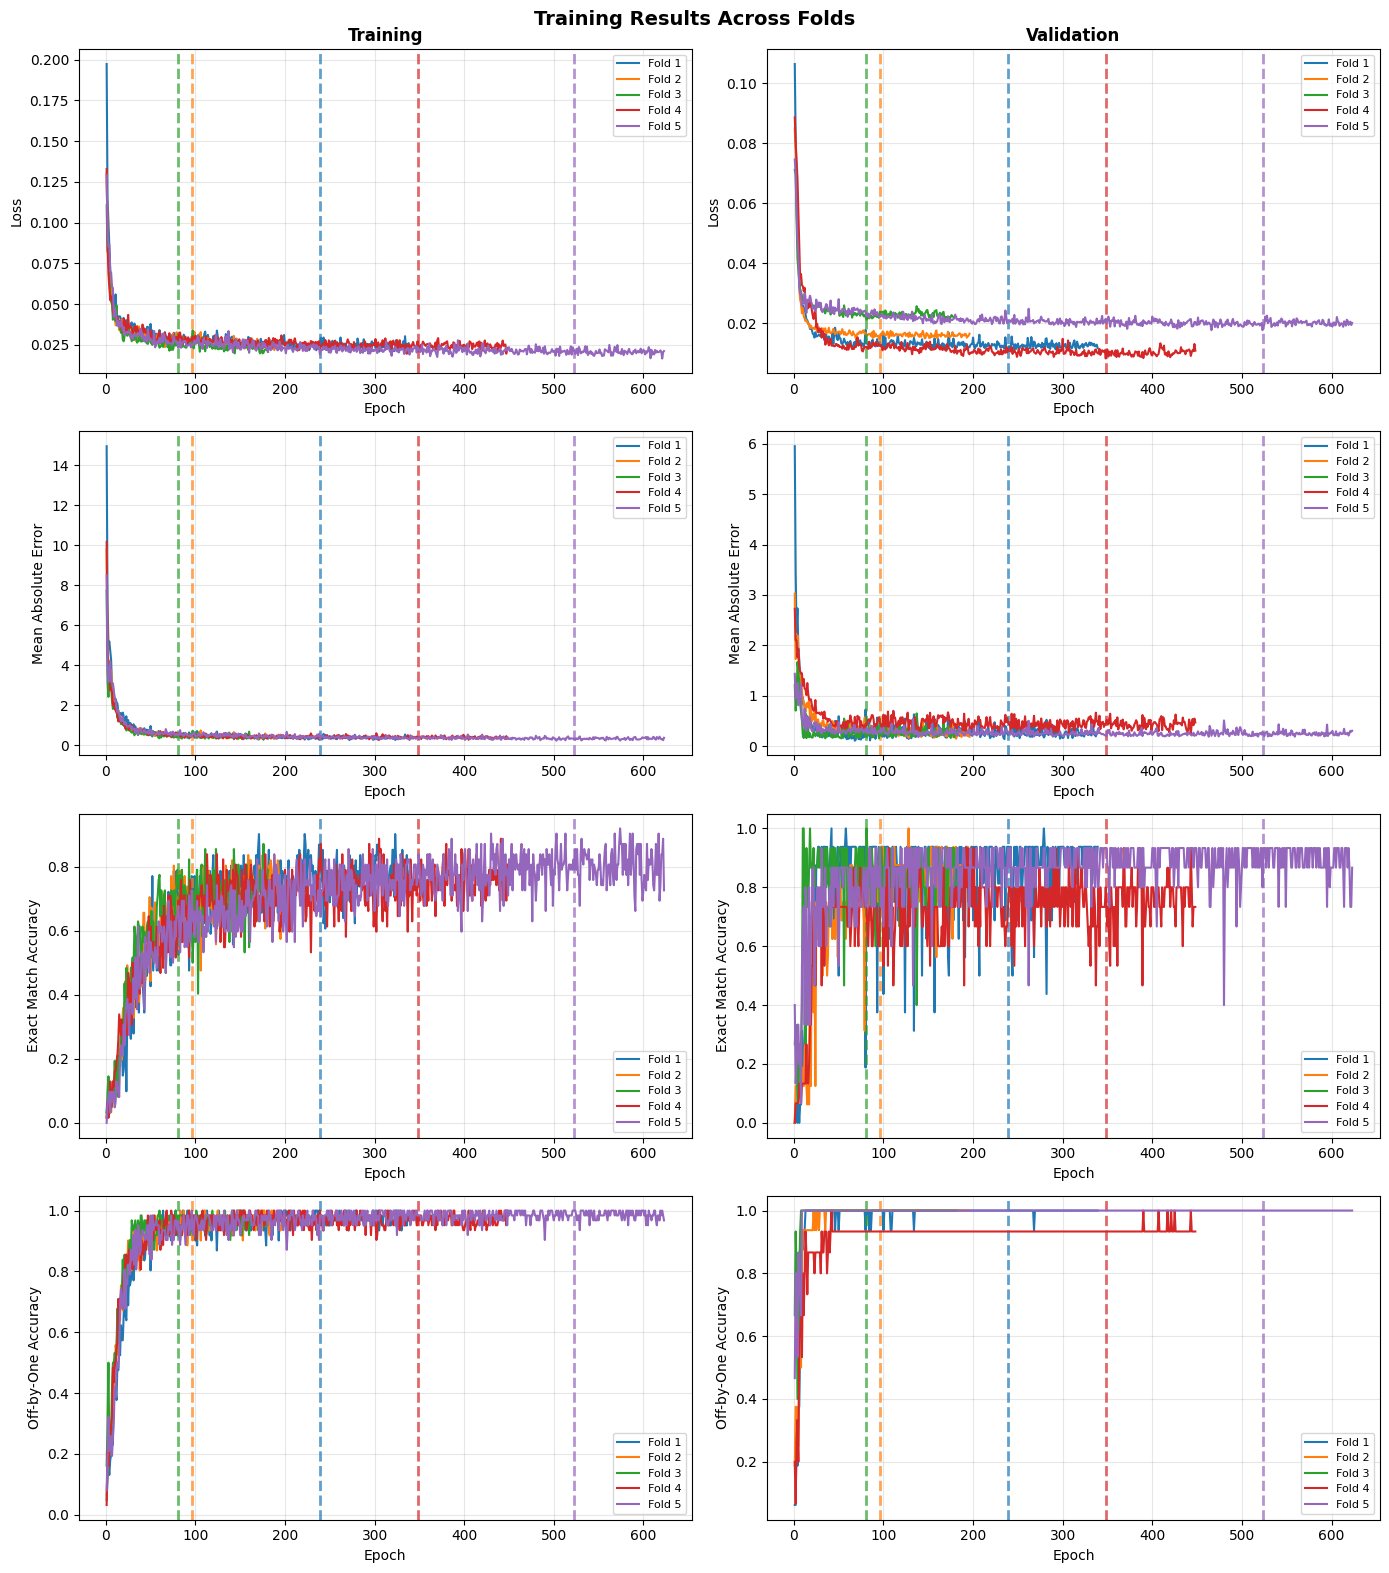

Training results saved to 'plots/training_results.png'


In [5]:
from evaluation.training_plots import plot_training_results

plot_training_results(training_results)

## Ensemble Evaluation

Evaluate the ensemble model on the full training dataset.

In [6]:
import pandas as pd
from evaluation.ensemble_evaluation import (
    evaluate_ensemble_on_dataset,
    plot_density_maps,
    plot_predicted_vs_true,
    plot_wrong_predictions_density_maps,
)

evaluation_results = evaluate_ensemble_on_dataset(model, "video-data")

metrics_df = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error',
        'Exact Match Accuracy',
        'Off-by-One Accuracy'
    ],
    'Value': [
        f"{evaluation_results['mae']:.4f}",
        f"{evaluation_results['exact_match_accuracy']:.2%}",
        f"{evaluation_results['off_by_one_accuracy']:.2%}"
    ]
})

print()
print("Ensemble Evaluation Results on Training Set")
metrics_df.style.hide(axis='index')


Ensemble Evaluation Results on Training Set


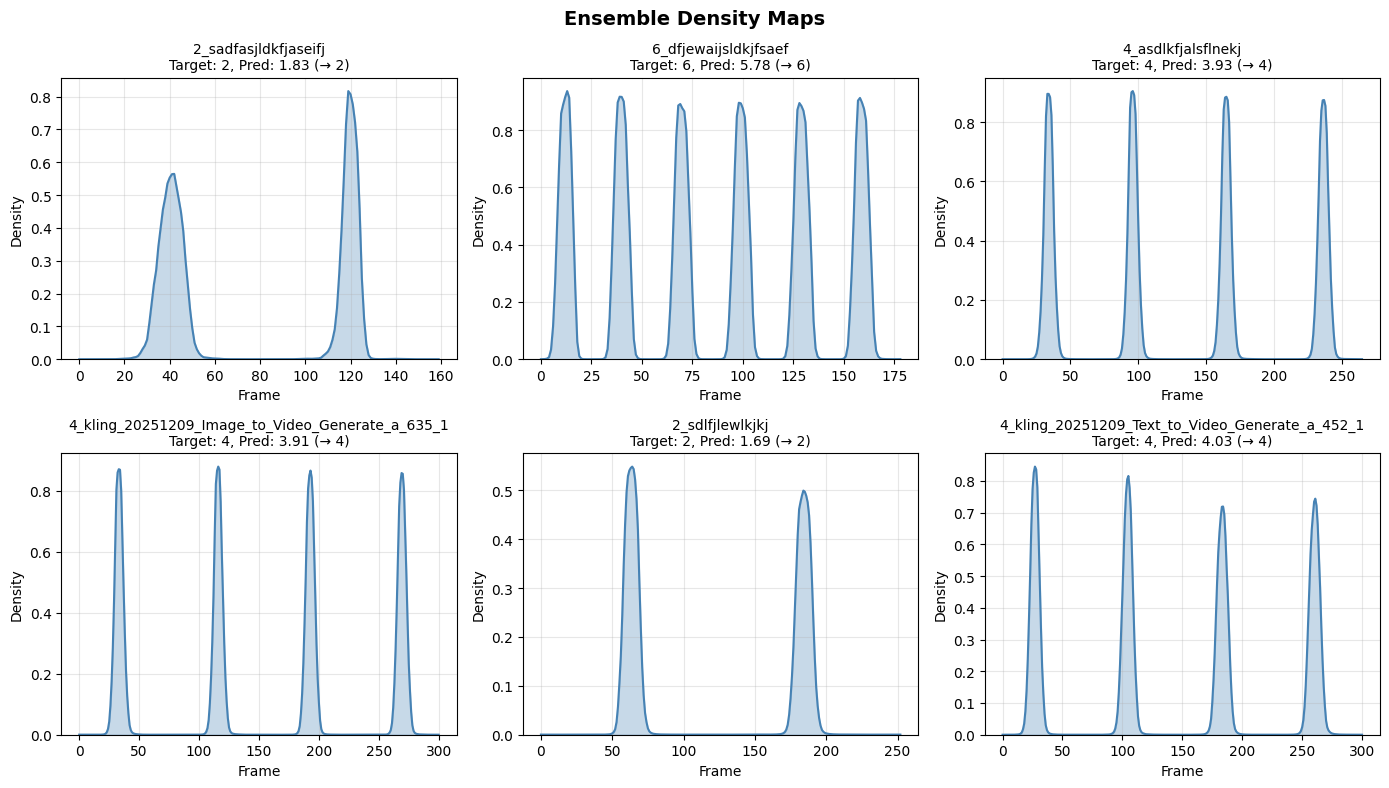

Density maps saved to 'plots/ensemble_density_maps.png'


In [7]:
plot_density_maps(evaluation_results, num_samples=6)

Only 3 wrong predictions found (requested 6)


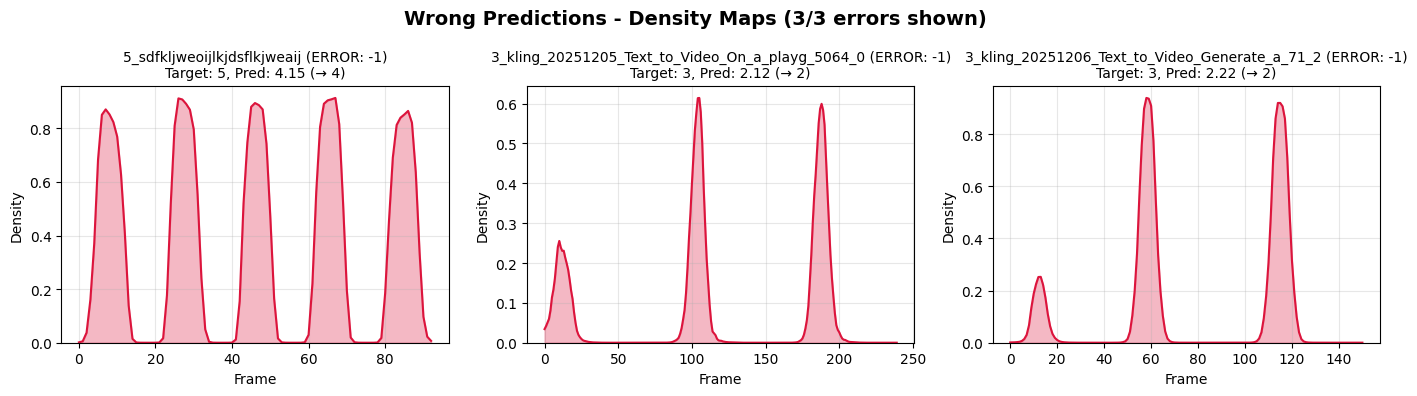

Wrong predictions density maps saved to 'plots/wrong_predictions_density_maps.png'
Total wrong predictions: 3 out of 77 samples (3.9%)


In [8]:
plot_wrong_predictions_density_maps(evaluation_results, num_samples=6)

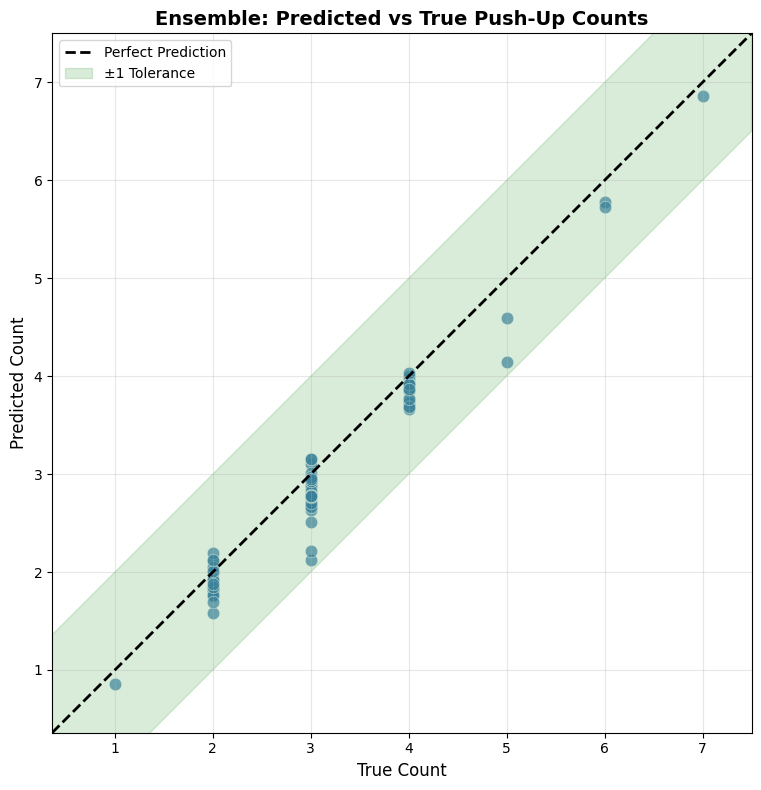

Plot saved to 'plots/predicted_vs_true.png'


In [9]:
plot_predicted_vs_true(evaluation_results)

## Validation on Unseen Data

Run the trained model against unseen validation data to evaluate generalization.

Found 5 validation videos
VALIDATION RESULTS ON UNSEEN DATA

        Video  True Count Predicted  Rounded    Result
4_pushups.mp4           4      3.61        4 ✓ Correct
8_pushups.mp4           8      8.25        8 ✓ Correct
9_pushups.mp4           9      8.14        8   ✗ Wrong
5_pushups.mp4           5      4.95        5 ✓ Correct
3_pushups.mp4           3      2.97        3 ✓ Correct

------------------------------------------------------------
Accuracy: 4/5 (80.0%)
------------------------------------------------------------


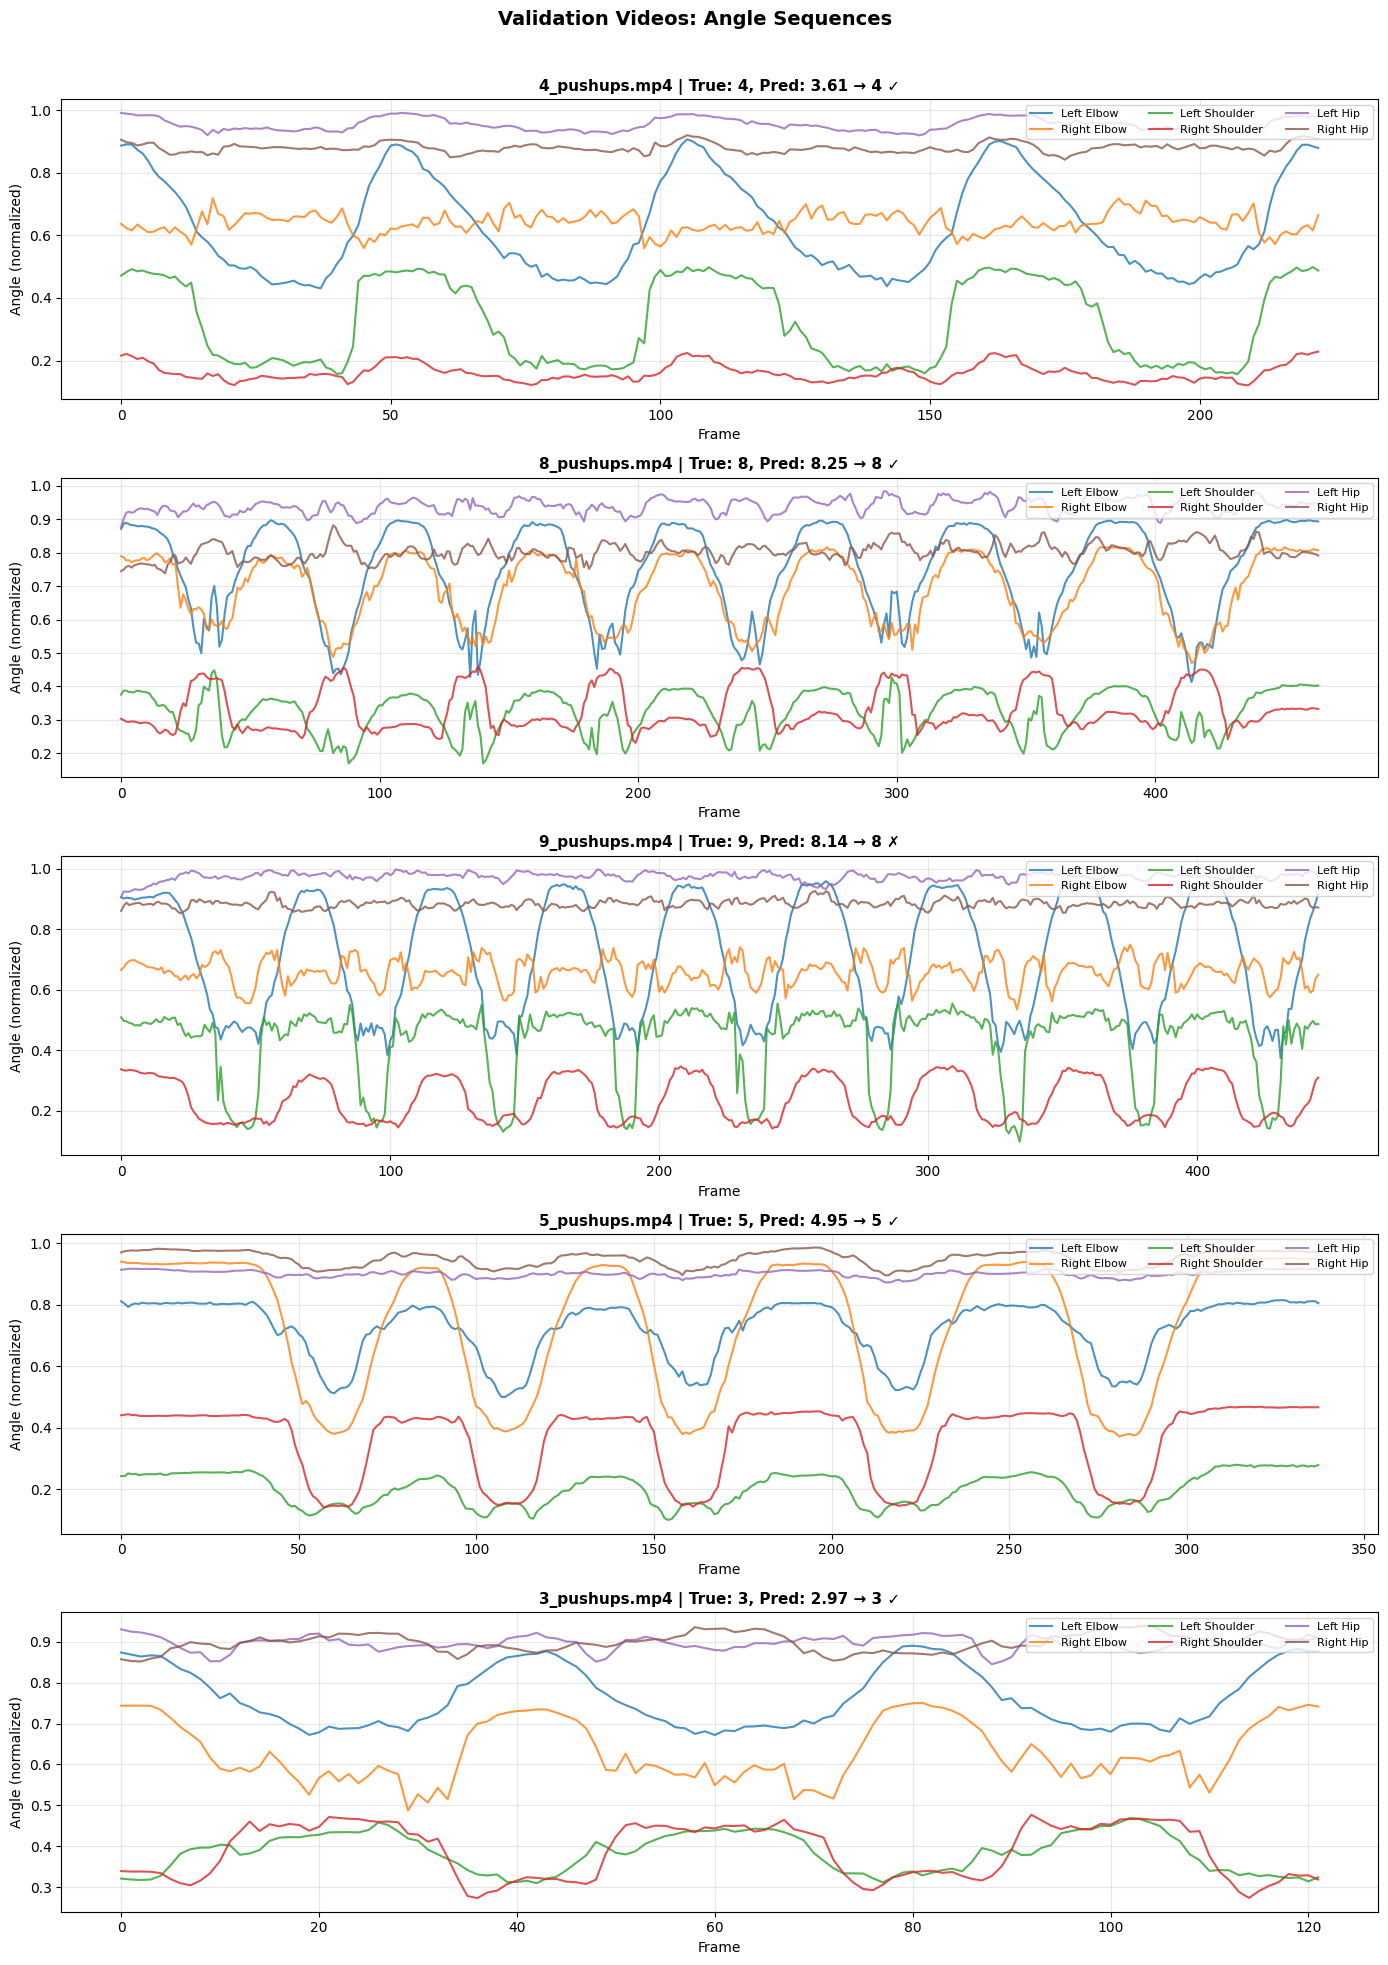

Angle sequences saved to 'plots/validation_angle_sequences.png'


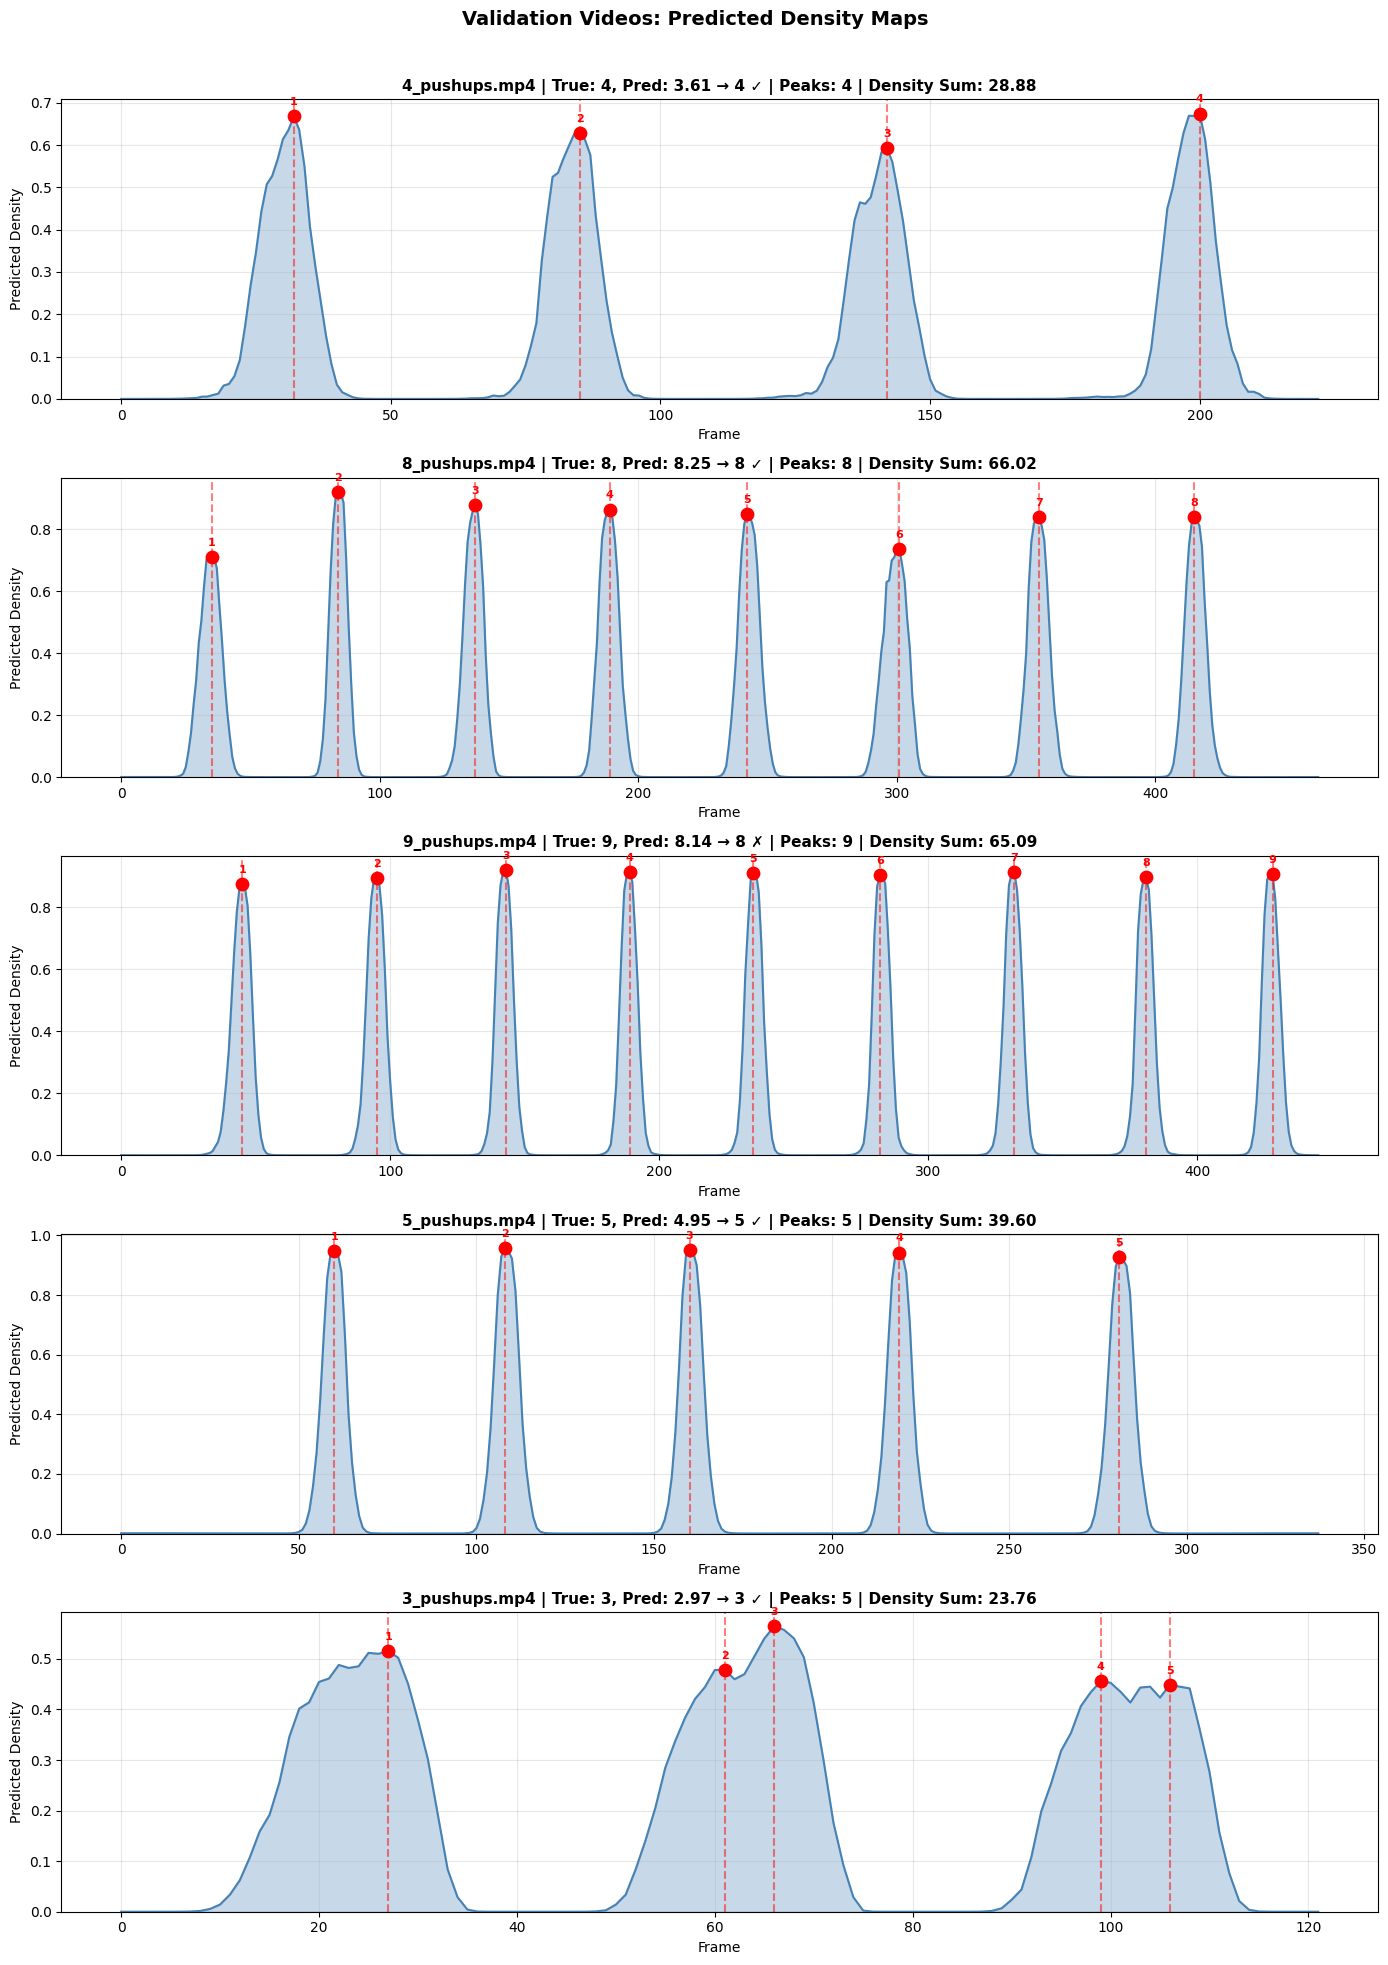

Density maps saved to 'plots/validation_density_maps.png'


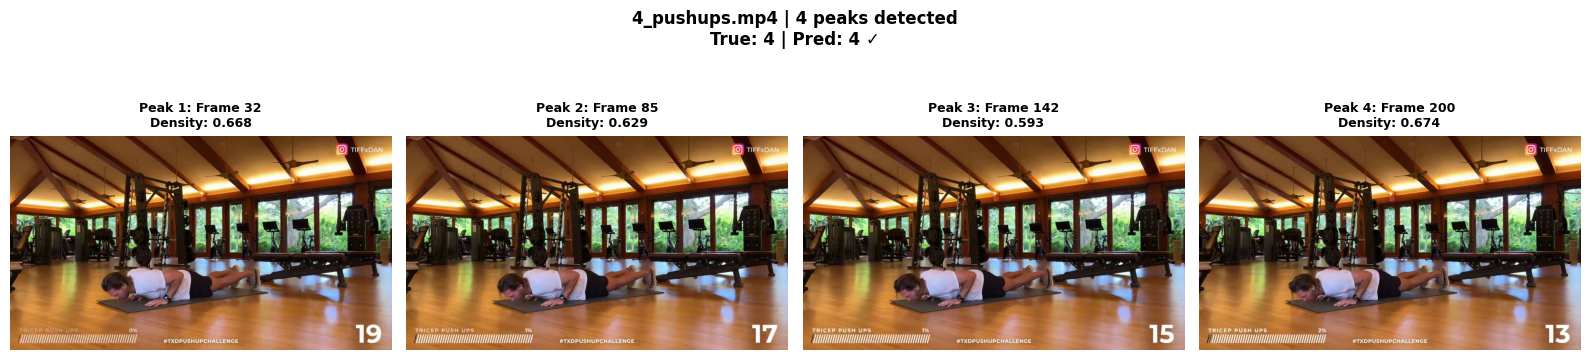

Peak frames saved to 'plots/validation_peaks_4_pushups.png'


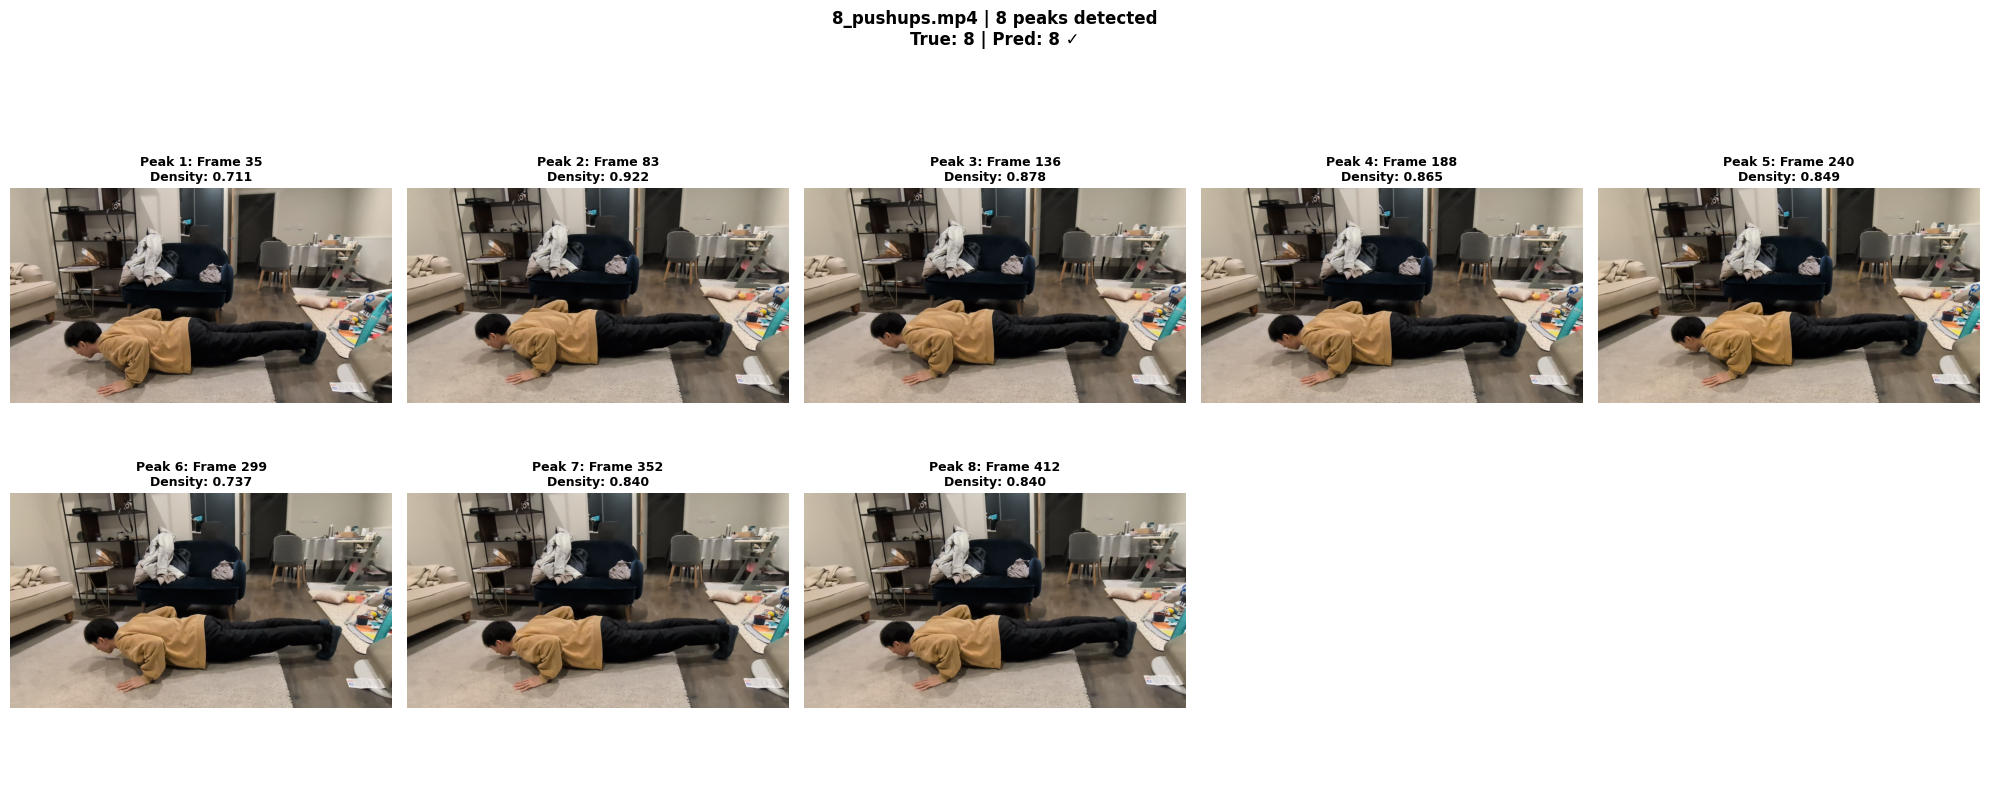

Peak frames saved to 'plots/validation_peaks_8_pushups.png'


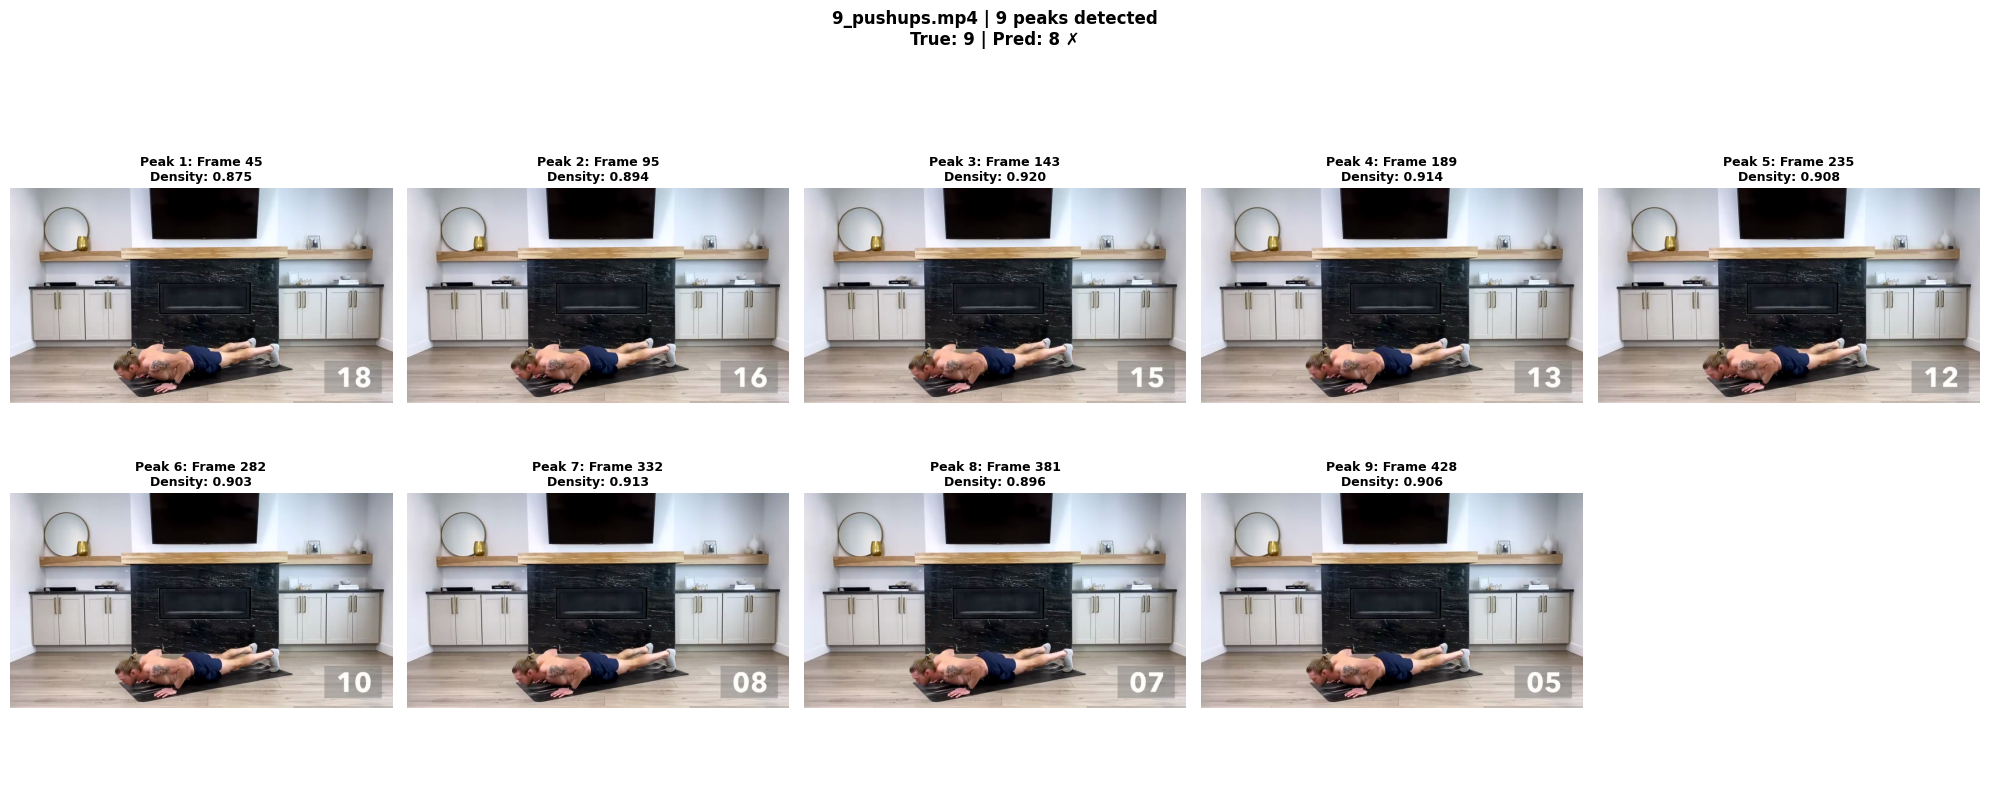

Peak frames saved to 'plots/validation_peaks_9_pushups.png'


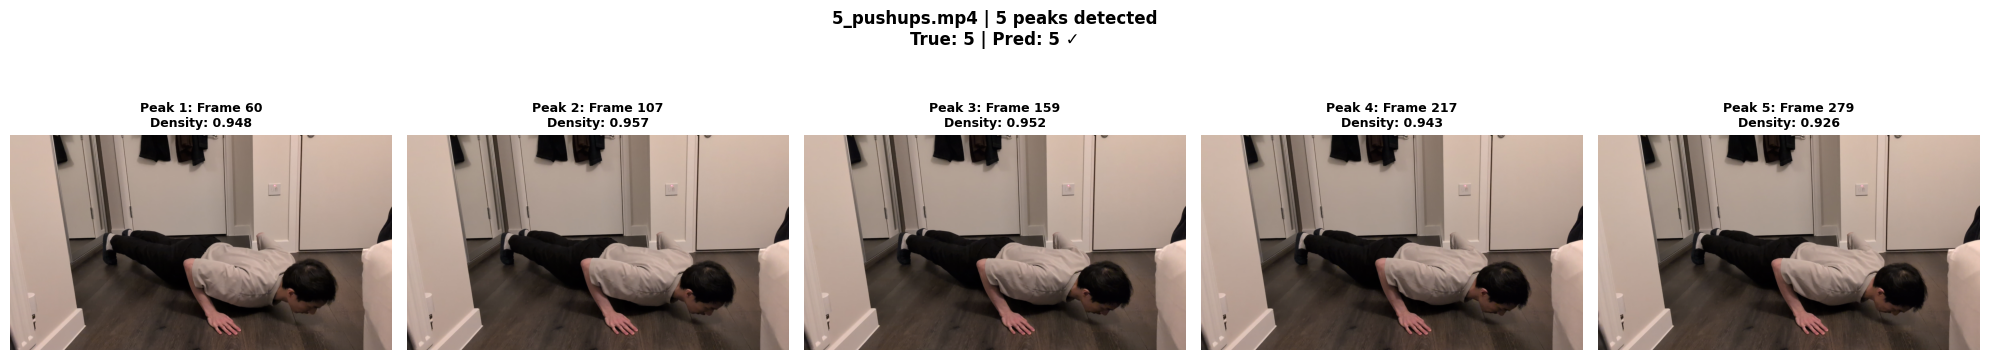

Peak frames saved to 'plots/validation_peaks_5_pushups.png'


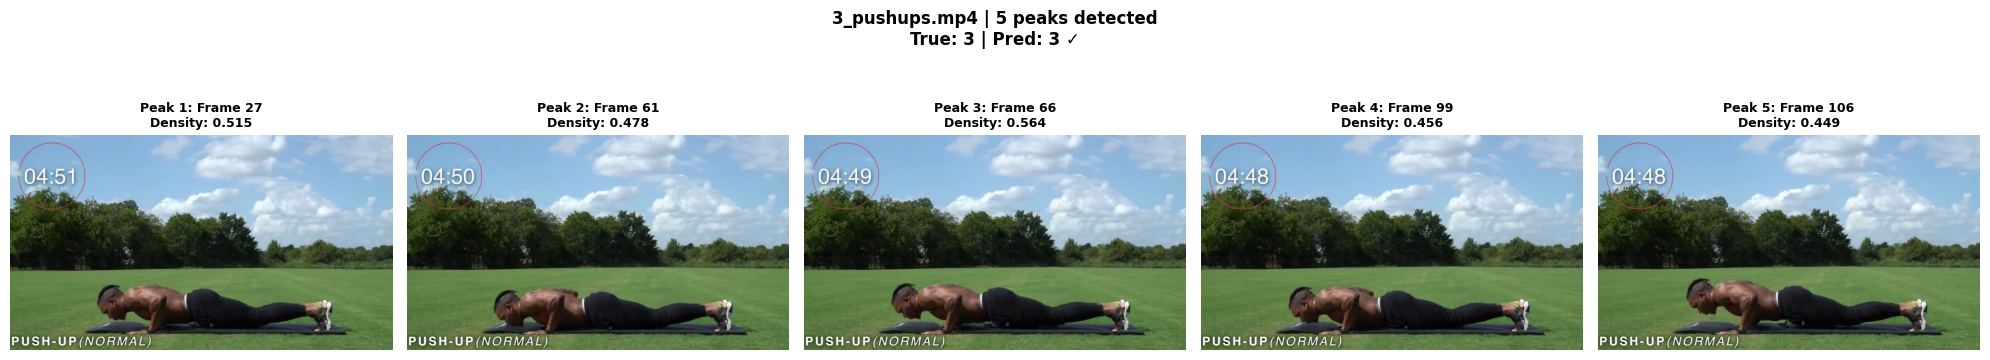

Peak frames saved to 'plots/validation_peaks_3_pushups.png'


In [11]:
from evaluation.validation import (
    evaluate_on_validation_data,
    display_validation_results,
    plot_validation_angle_sequences,
    plot_validation_density_maps,
    plot_peak_frames,
)

validation_results = evaluate_on_validation_data(model)

if validation_results:
    display_validation_results(validation_results)
    plot_validation_angle_sequences(validation_results)
    plot_validation_density_maps(validation_results)
    plot_peak_frames(validation_results)

## PCA Trajectory Visualization

Visualize the hidden state trajectory by extracting the 16-dimensional activations
from the `act3` layer and projecting them to 2D using PCA. Points are connected
in time order to show how the representation evolves.

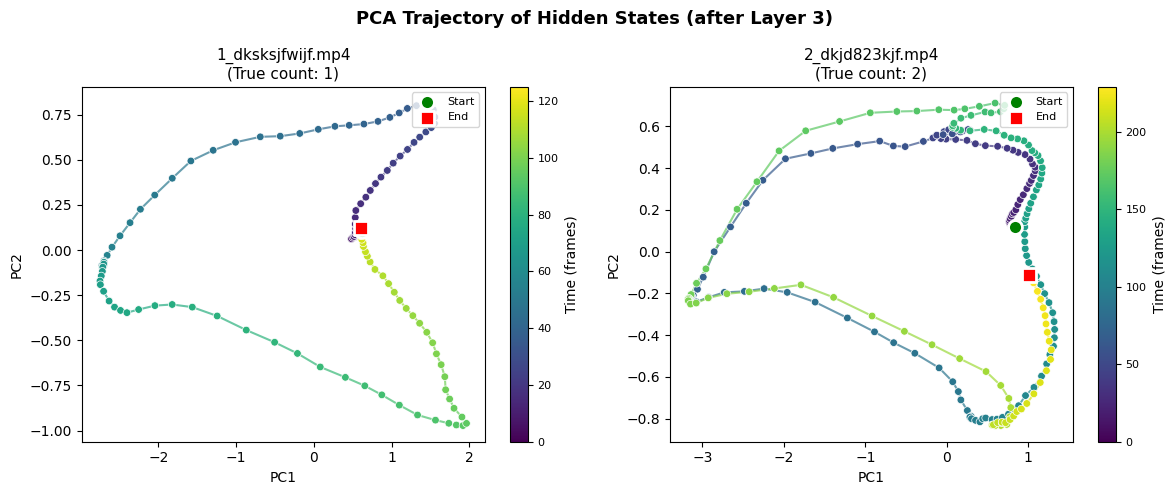

In [12]:
from evaluation.pca_trajectory import plot_pca_trajectories_for_samples

plot_pca_trajectories_for_samples(
    model,
    "video-data",
    video_filenames=[
        "1_dksksjfwijf.mp4",
        "2_dkjd823kjf.mp4",
    ],
);

## Layer-wise Temporal Activation Heatmaps

Visualize how activations evolve through each layer of the TCN.
Shows heatmaps for act1, act2, and act3 with hidden channels on Y-axis and time on X-axis.

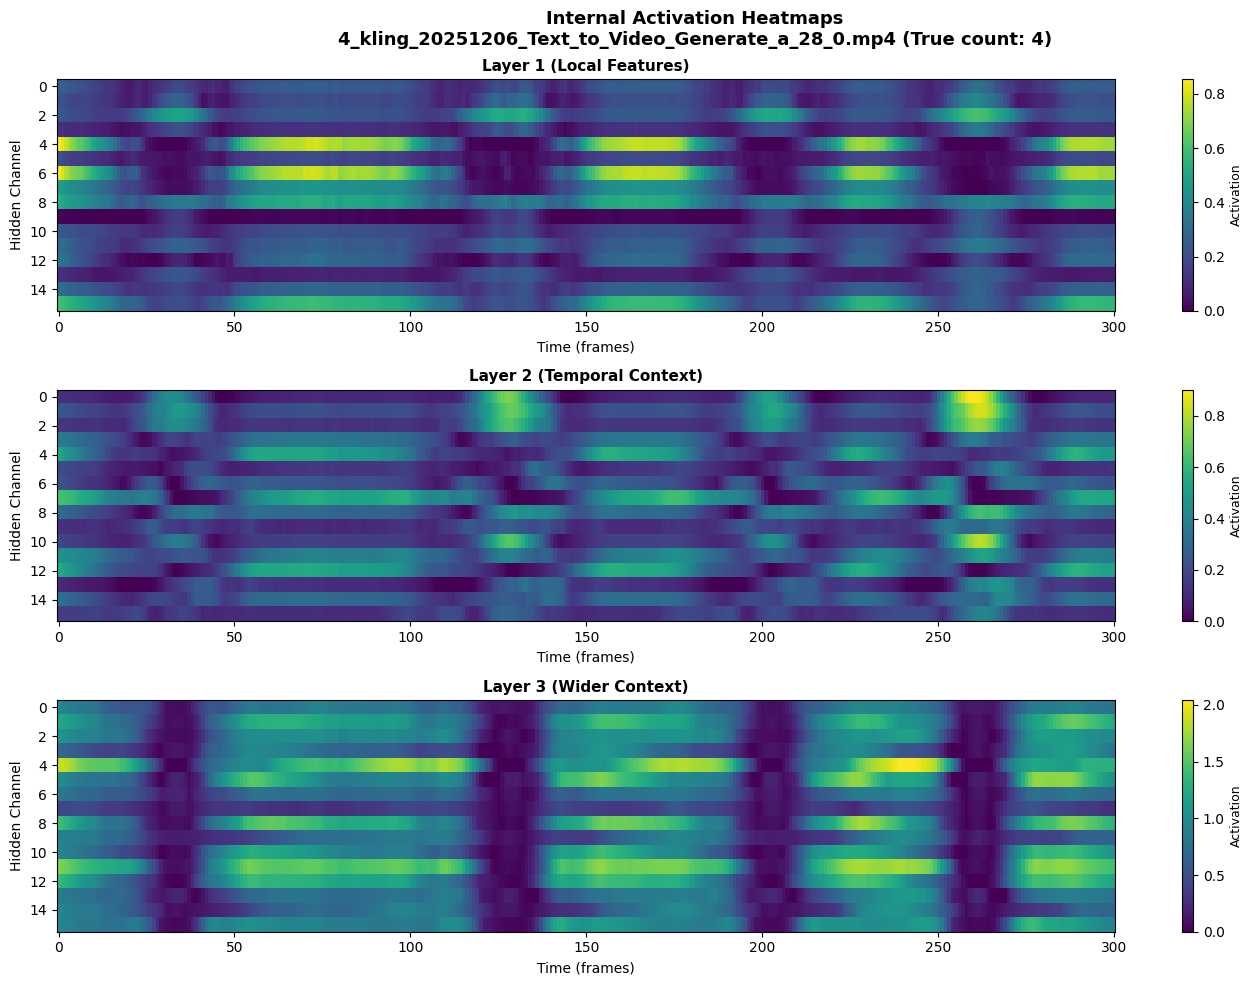

In [13]:
from evaluation.temporal_heatmaps import plot_temporal_activation_heatmaps

plot_temporal_activation_heatmaps(model, "video-data", filename="4_kling_20251206_Text_to_Video_Generate_a_28_0.mp4");

# Hugging Face

It is a requirement of this assignment that you submit your trained model to a repo on Hugging Face, and make it publicly available. Below, we provide code which should help you do this.

## TODO 7

Upload your model to HuggingFace

Install the dependencies:

In [14]:
!pip install huggingface_hub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


You'll now need to log in to Hugging Face via the command line. To do this, you'll need to generate a token on your Hugging Face account. To generate a token, run the below command, and click on the link which appears.

In [15]:
!hf auth login

User is already logged in.


The below code will only run if you have already trained a model with variable name 'model'.

The below code will take your trained model, and upload it to a *public* HuggingFace repo in your account called "mv-final-assignment".

(Note - in this example, we have set 'private=False' in the upload_to_hub method. This makes your model public).

You should double-check that your model is in fact public. To do that, you can navigate (in an incognito tab, in a browser) to https://huggingface.co/YOUR_USERNAME/YOUR_MODEL_NAME and see if that page loads. If your model is public, it will. (Simply being able to run the below code will not guarantee that your model is in fact public, because, you have now authenticated yourself with the huggingface CLI).

In [16]:
# YOUR HUGGING FACE USERNAME BELOW
hf_username = 'derekmok'

In [17]:
import torch
from huggingface_hub import HfApi


def save_model(model, path="model.pt"):
    """Save the model weights to a file."""
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def upload_to_hub(local_path="model.pt", repo_id=f"{hf_username}/mv-final-assignment"):
    """
    Upload model to Hugging Face Hub.

    Args:
        local_path: Path to your saved model file
        repo_id: Your repo in format "username/model-name"
    """
    api = HfApi()

    # Create the repo first (if it already exists, this will just skip)
    api.create_repo(
        repo_id=repo_id,
        repo_type="model",
        exist_ok=True,  # Don't error if it already exists
        private=False,  # Make it public so TAs can access
    )

    # Now upload the file
    api.upload_file(
        path_or_fileobj=local_path,
        path_in_repo="model.pt",
        repo_id=repo_id,
        repo_type="model",
    )

    print(f"Model uploaded to https://huggingface.co/{repo_id}")


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":

    save_model(model, "mv-final-assignment.pt")

    upload_to_hub("mv-final-assignment.pt", f"{hf_username}/mv-final-assignment")

Model saved to mv-final-assignment.pt


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Model uploaded to https://huggingface.co/derekmok/mv-final-assignment
